In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
gpu = tf.config.list_physical_devices('GPU')
print(f"tf Metal GPU: ", "Available" if gpu else "Not Available")

tf Metal GPU:  Available


In [2]:
! pip install imblearn

In [3]:
! ls ./Crime+Corpus/

Archive                      crime_cleaned_v1.csv
Chicago-Crimes-2018-2022.csv crime_cleaned_v2.csv
chicago_police_IUCR.csv      crime_cleaned_v3.csv
cities.json                  crimes_binary_v1.csv
crime+race.csv


In [4]:
crimes = pd.read_csv("./Crime+Corpus/crime_cleaned_v3.csv").drop("Unnamed: 0",axis=1)
crime_binary = pd.read_csv("./Crime+Corpus/crimes_binary_v1.csv").drop("Unnamed: 0",axis=1)
crime_binary.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Updated On,Latitude,Longitude,Location,Community Area Name,Dristrict-Name,SocioEconomic-Status,Hour,Day,Month
0,11515814,JB527247,2018-01-01 01:00:00,023XX S HOMAN AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,False,...,11/28/2018 04:14:58 PM,41.849030,-87.710045,"(41.849030217, -87.710044807)",South Lawndale,Ogden,High Income,1,1,1
1,11210595,JB125173,2018-01-01 01:00:00,007XX W GRACE ST,0890,THEFT,FROM BUILDING,APARTMENT,False,False,...,05/04/2018 03:51:04 PM,41.951457,-87.648582,"(41.951457303, -87.648582038)",Lake View,Town Hall,Low Income,1,1,1
2,11205233,JB117580,2018-01-01 01:00:00,006XX W HUTCHINSON ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,...,05/04/2018 03:51:04 PM,41.959354,-87.646931,"(41.95935351, -87.64693126)",Uptown,Town Hall,Moderate Income,1,1,1


#### Two types of Data Classification
---
1. Incarceration -- same data as SVM
2. Top3 Crime Classification

In [5]:
crime_binary['Date'] = pd.to_datetime(crime_binary['Date'])
crime_binary['dayofweek'] = crime_binary["Date"].dt.strftime("%a")
crime_binary['dayofweek']

0          Mon
1          Mon
2          Mon
3          Mon
4          Mon
          ... 
1175724    Sat
1175725    Sat
1175726    Sat
1175727    Sat
1175728    Sat
Name: dayofweek, Length: 1175729, dtype: object

### Neural Network for Incarceration

In [19]:
### Incarceration Data
crime_arrest = crime_binary.copy(deep=True)

# select features and target variable
features = ['Block','Primary Type', 'Description','Community Area','Location Description','SocioEconomic-Status','dayofweek']
target = 'Arrest'

# encode categorical features
for feature in features:
    if crime_arrest[feature].dtype == 'object':
        crime_arrest[feature] = pd.factorize(crime_arrest[feature])[0]
        
crime_arrest

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Latitude,Longitude,Location,Community Area Name,Dristrict-Name,SocioEconomic-Status,Hour,Day,Month,dayofweek
0,11515814,JB527247,2018-01-01 01:00:00,0,0560,0,0,0,False,False,...,41.849030,-87.710045,"(41.849030217, -87.710044807)",South Lawndale,Ogden,0,1,1,1,0
1,11210595,JB125173,2018-01-01 01:00:00,1,0890,1,1,0,False,False,...,41.951457,-87.648582,"(41.951457303, -87.648582038)",Lake View,Town Hall,1,1,1,1,0
2,11205233,JB117580,2018-01-01 01:00:00,2,0281,2,2,1,False,True,...,41.959354,-87.646931,"(41.95935351, -87.64693126)",Uptown,Town Hall,2,1,1,1,0
3,11192281,JB100080,2018-01-01 01:00:00,3,0486,3,3,2,True,True,...,41.653221,-87.545916,"(41.653220991, -87.54591594)",Hegewisch,South Chicago,2,1,1,1,0
4,11193559,JB100825,2018-01-01 01:00:00,4,0870,1,4,2,False,False,...,41.893677,-87.635628,"(41.893676531, -87.635628328)",Near North Side,Near North,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175724,12937789,JF528687,2022-12-31 12:45:00,12251,1310,7,13,13,False,False,...,41.874153,-87.735239,"(41.874153389, -87.735238688)",West Garfield Park,Harrison,0,12,31,12,4
1175725,12938029,JF528801,2022-12-31 12:50:00,3209,0560,0,0,0,False,False,...,41.855911,-87.719966,"(41.855911352, -87.719966)",North Lawndale,Ogden,0,12,31,12,4
1175726,12937822,JF528703,2022-12-31 12:50:00,364,051A,0,99,0,False,True,...,41.766546,-87.645669,"(41.766545786, -87.64566932)",Englewood,Englewood,0,12,31,12,4
1175727,12937583,JF528218,2022-12-31 00:52:00,19949,0460,3,0,43,False,False,...,41.868829,-87.686098,"(41.868829303, -87.686098247)",Near West Side,Harrison,2,0,31,12,4


<Axes: xlabel='Arrest'>

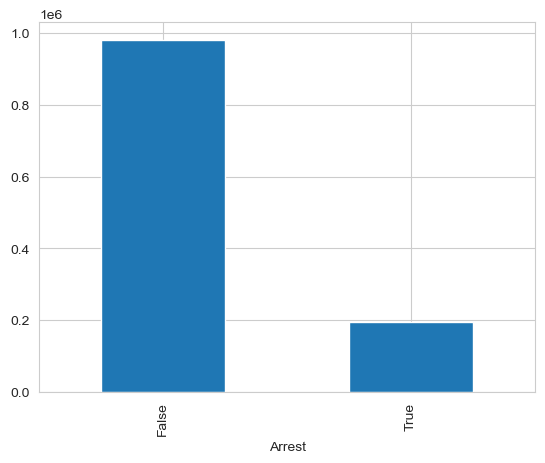

In [20]:
crime_arrest[target].value_counts().plot(kind='bar')

In [21]:
# Downsampling and Normalizing
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = crime_arrest[features], crime_arrest[target]

print(f"Features {features}")
print(f'Class: {target}')

print(f'Class Balance: {y.value_counts()}')
smote_enn = SMOTEENN(random_state=42,)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

print('- Undersampling Data.')

print('Class distribution after undersampling:')
print(pd.Series(y_resampled).value_counts())

print('Scaling Numericals')
# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler on the data
scaler.fit(X)

# transform the data using the scaler
X_scaled = scaler.transform(X_resampled)


Features ['Block', 'Primary Type', 'Description', 'Community Area', 'Location Description', 'SocioEconomic-Status', 'dayofweek']
Class: Arrest
Class Balance: Arrest
False    980840
True     194889
Name: count, dtype: int64
- Undersampling Data.
Class distribution after undersampling:
Arrest
True     720877
False    645523
Name: count, dtype: int64
Scaling Numericals


In [22]:
# Sampling 
data = pd.DataFrame(X_scaled)
data['target'] = y_resampled
data = data.sample(10000)
X = data.drop('target',axis=1)
y = data['target']

print(f'Creating Distributions Train: 70, Test: 30')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=101)


Creating Distributions Train: 70, Test: 30


### Model Building

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [19]:
X_train.shape

(7000, 7)

In [20]:
nnet = Sequential()

nnet.add(Dense(units=7, activation='relu', ))
nnet.add(Dense(units=15, activation='relu', ))
nnet.add(Dense(units=20, activation='relu', ))
nnet.add(Dense(units=1, activation='sigmoid',))
# For a binary classification problem
nnet.compile(loss='binary_crossentropy', optimizer='adam')

In [21]:
nnet.build(input_shape=X_train.shape)

In [22]:
nnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (7000, 7)                 56        
                                                                 
 dense_5 (Dense)             (7000, 15)                120       
                                                                 
 dense_6 (Dense)             (7000, 20)                320       
                                                                 
 dense_7 (Dense)             (7000, 1)                 21        
                                                                 
Total params: 517
Trainable params: 517
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = nnet.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
           callbacks=[early_stop]
          )

Epoch 1/600
219/219 [==============================] - 2s 8ms/step - loss: 0.6073 - val_loss: 0.5495
Epoch 2/600
219/219 [==============================] - 2s 7ms/step - loss: 0.5434 - val_loss: 0.5398
Epoch 3/600
219/219 [==============================] - 2s 7ms/step - loss: 0.5362 - val_loss: 0.5353
Epoch 4/600
219/219 [==============================] - 2s 7ms/step - loss: 0.5330 - val_loss: 0.5340
Epoch 5/600
219/219 [==============================] - 2s 7ms/step - loss: 0.5305 - val_loss: 0.5310
Epoch 6/600
219/219 [==============================] - 2s 7ms/step - loss: 0.5282 - val_loss: 0.5276
Epoch 7/600
219/219 [==============================] - 2s 7ms/step - loss: 0.5265 - val_loss: 0.5250
Epoch 8/600
219/219 [==============================] - 2s 8ms/step - loss: 0.5233 - val_loss: 0.5231
Epoch 9/600
219/219 [==============================] - 2s 8ms/step - loss: 0.5211 - val_loss: 0.5214
Epoch 10/600
219/219 [==============================] - 2s 8ms/step - loss: 0.5190 - val_lo

Epoch 161/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3717 - val_loss: 0.4102
Epoch 162/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3719 - val_loss: 0.4062
Epoch 163/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3707 - val_loss: 0.4074
Epoch 164/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3710 - val_loss: 0.4050
Epoch 165/600
219/219 [==============================] - 2s 8ms/step - loss: 0.3719 - val_loss: 0.4082
Epoch 166/600
219/219 [==============================] - 2s 8ms/step - loss: 0.3709 - val_loss: 0.4087
Epoch 167/600
219/219 [==============================] - 2s 8ms/step - loss: 0.3711 - val_loss: 0.4073
Epoch 168/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3715 - val_loss: 0.4089
Epoch 169/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3706 - val_loss: 0.4110
Epoch 170/600
219/219 [==============================] - 2s 7ms/step - lo

Text(0.5, 1.0, 'Loss Vs Validation Loss')

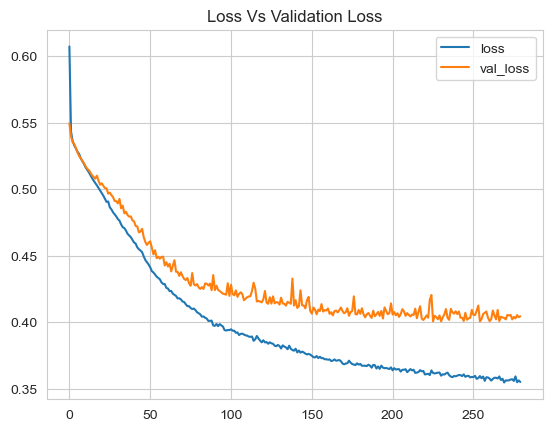

In [30]:
model_data = pd.DataFrame(history.history)
model_data.plot()
plt.title('Loss Vs Validation Loss')

In [81]:
from sklearn.metrics import confusion_matrix, classification_report
def decode(predictions):
    # model to decode sigmoid probabilities back to Binary
    return [True if pred[0] > 0.5 else False for pred in predictions]

def evaluate(model, y_test, output='report'):
    predictions = model.predict(X_test)
    print()
    if output == 'report':
        print(classification_report(y_test,decode(predictions)))
    elif output=='conf-mat':
        sns.heatmap(confusion_matrix(y_test, decode(predictions)), 
                    annot=True, cmap='Blues',fmt='d', xticklabels=['True','False'], 
                    yticklabels=['True','False'])
        plt.title('Confusion Matrix')
        plt.show()

        				

In [77]:
evaluate(nnet, y_test, output='report')

94/94 [==============================] - 0s 3ms/step

              precision    recall  f1-score   support

       False       0.76      0.86      0.81      1394
        True       0.86      0.77      0.81      1606

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.82      0.81      0.81      3000



94/94 [==============================] - 0s 2ms/step



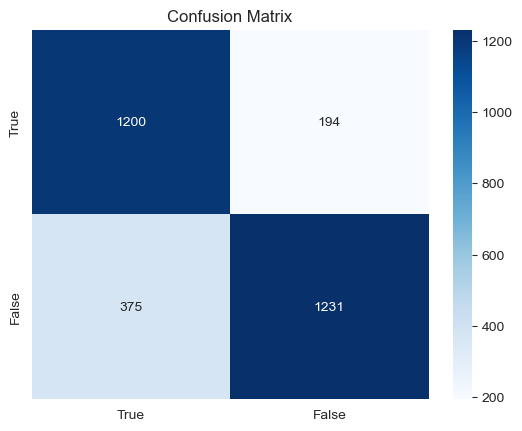

In [82]:
evaluate(nnet, y_test, output='conf-mat')

### Suggested Network Architecture 

In [38]:
nnet_suggested = Sequential()
nnet_suggested.add(Dense(units=3, activation='relu', ))
nnet_suggested.add(Dense(units=1, activation='sigmoid',))
# For a binary classification problem
nnet_suggested.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [32]:
nnet_suggested.build(input_shape=X_train)

In [36]:
nnet_suggested.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (0, 1, 2, 3, 4, 5, 3)     21        
                                                                 
 dense_9 (Dense)             (0, 1, 2, 3, 4, 5, 1)     4         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = nnet.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
           callbacks=[early_stop]
          )

Epoch 1/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3553 - val_loss: 0.4006
Epoch 2/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3559 - val_loss: 0.4035
Epoch 3/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3553 - val_loss: 0.4055
Epoch 4/600
219/219 [==============================] - 2s 9ms/step - loss: 0.3548 - val_loss: 0.4023
Epoch 5/600
219/219 [==============================] - 2s 8ms/step - loss: 0.3536 - val_loss: 0.4035
Epoch 6/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3546 - val_loss: 0.4103
Epoch 7/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3562 - val_loss: 0.4033
Epoch 8/600
219/219 [==============================] - 2s 7ms/step - loss: 0.3538 - val_loss: 0.4042
Epoch 9/600
219/219 [==============================] - 2s 8ms/step - loss: 0.3554 - val_loss: 0.4052
Epoch 10/600
219/219 [==============================] - 2s 8ms/step - loss: 0.3545 - val_lo

<Axes: >

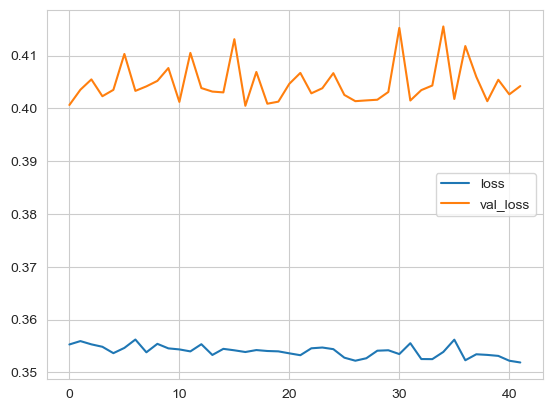

In [84]:
pd.DataFrame(history.history).plot()

In [85]:
evaluate(nnet_suggested, y_test, output='report')

94/94 [==============================] - 0s 2ms/step

              precision    recall  f1-score   support

       False       0.36      0.52      0.42      1394
        True       0.32      0.20      0.25      1606

    accuracy                           0.35      3000
   macro avg       0.34      0.36      0.33      3000
weighted avg       0.34      0.35      0.33      3000



94/94 [==============================] - 0s 2ms/step



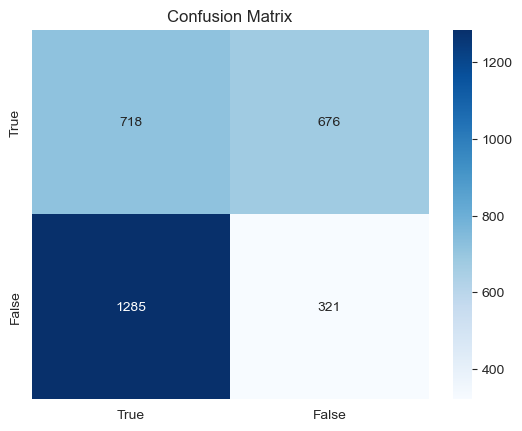

In [86]:
evaluate(nnet_suggested, y_test, output='conf-mat')

### Type of Crime

In [26]:
crimes.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Community Area Name,Dristrict-Name,SocioEconomic-Status,dayofweek
0,11515814,JB527247,2018-01-01 01:00:00,023XX S HOMAN AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,False,...,1888193.0,2018,11/28/2018 04:14:58 PM,41.849030,-87.710045,"(41.849030217, -87.710044807)",South Lawndale,Ogden,High Income,Mon
1,11210595,JB125173,2018-01-01 01:00:00,007XX W GRACE ST,0890,THEFT,FROM BUILDING,APARTMENT,False,False,...,1925645.0,2018,05/04/2018 03:51:04 PM,41.951457,-87.648582,"(41.951457303, -87.648582038)",Lake View,Town Hall,Low Income,Mon


In [27]:
crimes.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Area Name', 'Dristrict-Name',
       'SocioEconomic-Status', 'dayofweek'],
      dtype='object')

In [28]:
crimes['Date'] = pd.to_datetime(crimes['Date'])
crimes['dayofweek'] = crimes["Date"].dt.strftime("%a")
crimes['dayofweek']

0          Mon
1          Mon
2          Mon
3          Mon
4          Mon
          ... 
1175724    Sat
1175725    Sat
1175726    Sat
1175727    Sat
1175728    Sat
Name: dayofweek, Length: 1175729, dtype: object

In [29]:
features = ['Arrest', 'Description','Community Area','Location Description','Domestic','SocioEconomic-Status','dayofweek']
target = 'Primary Type'

In [30]:
df = crimes[target]
df

0                      ASSAULT
1                        THEFT
2          CRIM SEXUAL ASSAULT
3                      BATTERY
4                        THEFT
                  ...         
1175724        CRIMINAL DAMAGE
1175725                ASSAULT
1175726                ASSAULT
1175727                BATTERY
1175728                ASSAULT
Name: Primary Type, Length: 1175729, dtype: object

<Axes: ylabel='Primary Type'>

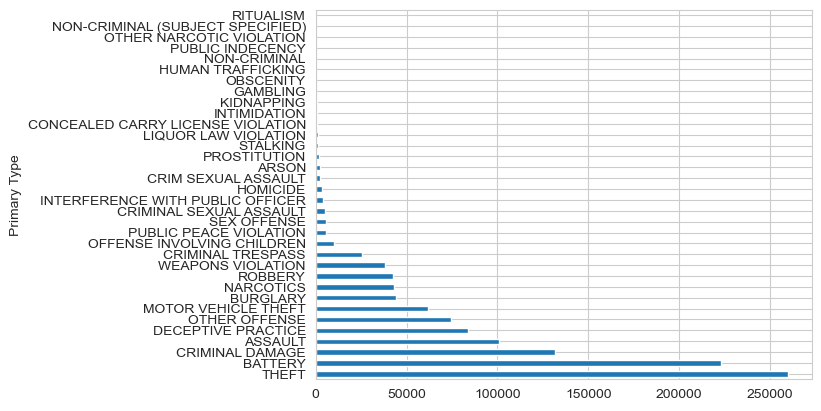

In [31]:
df.value_counts().plot(kind='barh')

In [32]:
crimesofinterest = ['THEFT','ASSUALT','BATTERY','ROBBERY','NARCOTICS','CRIMINAL DAMAGE']
featured_data = crimes[features]
featured_data[target] = crimes[target]

/var/folders/5r/pnlff12n2d55g65_tnn3b1pw0000gn/T/ipykernel_66104/3531833374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_data[target] = crimes[target]


In [33]:
featured_data = featured_data[featured_data['Primary Type'].isin(crimesofinterest)]

In [34]:
featured_data[target].unique()

array(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ROBBERY'],
      dtype=object)

### Encoding

In [35]:
### Incarceration Data
crime_type = featured_data.copy(deep=True)

# select features and target variable
features = ['Arrest', 'Description','Community Area','Location Description','Domestic','SocioEconomic-Status','dayofweek']
target = 'Primary Type'

# encode categorical features
for feature in features:
    if crime_type[feature].dtype == 'object':
        crime_type[feature] = pd.factorize(crime_type[feature])[0]
        
crime_type

,Arrest,Description,Community Area,Location Description,Domestic,SocioEconomic-Status,dayofweek,Primary Type
1,False,0,6,0,False,0,0,THEFT
3,True,1,55,1,True,1,0,BATTERY
4,False,2,8,1,False,0,0,THEFT
7,False,0,8,2,False,0,0,THEFT
8,False,2,8,1,False,0,0,THEFT
...,...,...,...,...,...,...,...,...
1175716,False,6,61,12,False,2,4,CRIMINAL DAMAGE
1175717,False,68,60,13,False,1,4,BATTERY
1175722,False,60,3,53,False,1,4,BATTERY
1175724,False,6,26,12,False,2,4,CRIMINAL DAMAGE


### Scaling Everything in Target Column

In [36]:
# apply near miss
from imblearn.under_sampling import NearMiss

X, y = crime_type[features], crime_type[target]

print(f"Features {features}")
print(f'Class: {target}')

print(f'Class Balance: {y.value_counts()}')
nr = NearMiss()
X_resampled, y_resampled = nr.fit_resample(X, y)

print('- Undersampling Data.')

print('Class distribution after undersampling:')
print(pd.Series(y_resampled).value_counts())

print('Scaling Numericals')
# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler on the data
scaler.fit(X)

# transform the data using the scaler
X_scaled = scaler.transform(X_resampled)

Features ['Arrest', 'Description', 'Community Area', 'Location Description', 'Domestic', 'SocioEconomic-Status', 'dayofweek']
Class: Primary Type
Class Balance: Primary Type
THEFT              259911
BATTERY            222924
CRIMINAL DAMAGE    131871
NARCOTICS           43335
ROBBERY             42792
Name: count, dtype: int64
- Undersampling Data.
Class distribution after undersampling:
Primary Type
BATTERY            42792
CRIMINAL DAMAGE    42792
NARCOTICS          42792
ROBBERY            42792
THEFT              42792
Name: count, dtype: int64
Scaling Numericals


In [37]:
df_nrsc = pd.DataFrame(X_scaled)
df_nrsc 

,0,1,2,3,4,5,6
0,-0.432065,1.863687,1.448067,-0.477780,-0.513857,1.348395,-0.515214
1,-0.432065,1.863687,1.448067,-0.477780,-0.513857,1.348395,-0.515214
2,-0.432065,1.863687,0.606077,-0.323050,-0.513857,-0.040202,-1.019331
3,-0.432065,1.863687,-0.469798,-0.323050,-0.513857,1.348395,1.501255
4,-0.432065,1.863687,-0.516576,0.037986,-0.513857,-0.040202,1.501255
...,...,...,...,...,...,...,...
213955,-0.432065,-0.246879,-0.750462,-0.477780,-0.513857,-0.040202,-1.523448
213956,-0.432065,-0.246879,0.231859,-0.477780,-0.513857,-1.428799,-1.523448
213957,2.314468,-0.246879,1.541621,-0.477780,-0.513857,-0.040202,-1.523448
213958,-0.432065,-0.246879,-0.750462,-0.477780,-0.513857,-0.040202,-1.523448


In [38]:
final_data = pd.concat([df_nrsc,pd.get_dummies(y_resampled)],axis=1)

In [39]:
final_data

,0,1,2,3,4,5,6,BATTERY,CRIMINAL DAMAGE,NARCOTICS,ROBBERY,THEFT
0,-0.432065,1.863687,1.448067,-0.477780,-0.513857,1.348395,-0.515214,True,False,False,False,False
1,-0.432065,1.863687,1.448067,-0.477780,-0.513857,1.348395,-0.515214,True,False,False,False,False
2,-0.432065,1.863687,0.606077,-0.323050,-0.513857,-0.040202,-1.019331,True,False,False,False,False
3,-0.432065,1.863687,-0.469798,-0.323050,-0.513857,1.348395,1.501255,True,False,False,False,False
4,-0.432065,1.863687,-0.516576,0.037986,-0.513857,-0.040202,1.501255,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
213955,-0.432065,-0.246879,-0.750462,-0.477780,-0.513857,-0.040202,-1.523448,False,False,False,False,True
213956,-0.432065,-0.246879,0.231859,-0.477780,-0.513857,-1.428799,-1.523448,False,False,False,False,True
213957,2.314468,-0.246879,1.541621,-0.477780,-0.513857,-0.040202,-1.523448,False,False,False,False,True
213958,-0.432065,-0.246879,-0.750462,-0.477780,-0.513857,-0.040202,-1.523448,False,False,False,False,True


In [40]:
classes = list(final_data.columns[-5:])
classes

['BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ROBBERY', 'THEFT']

In [41]:
X = final_data.drop(classes, axis=1)
y = final_data[classes]
X = X.values
y = y.values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=101)

### Multi-Class Classification

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

from tensorflow.keras.callbacks import EarlyStopping

In [45]:
nnet_multiclass = Sequential()

nnet_multiclass.add(Dense(units=16,activation='relu'))
nnet_multiclass.add(Dense(units=25,activation='relu'))
nnet_multiclass.add(Dense(units=5, activation='softmax'))

nnet_multiclass.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [46]:
X_train.shape

(149772, 7)

In [47]:
nnet_multiclass.build(input_shape=X_train.shape)

In [48]:
nnet_multiclass.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (149772, 16)              128       
                                                                 
 dense_4 (Dense)             (149772, 25)              425       
                                                                 
 dense_5 (Dense)             (149772, 5)               130       
                                                                 
Total params: 683
Trainable params: 683
Non-trainable params: 0
_________________________________________________________________


In [49]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)

In [50]:
multiclass_data = nnet_multiclass.fit(x=X_train, 
          y=y_train, 
          epochs=50,
          validation_data=(X_test, y_test), verbose=1,
           callbacks=[early_stop]
          )

Epoch 1/50


2023-04-30 21:07:41.743895: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4681/4681 [==============================] - 60s 13ms/step - loss: 0.5976 - accuracy: 0.7927 - val_loss: 0.3138 - val_accuracy: 0.9172
Epoch 2/50
4681/4681 [==============================] - 58s 12ms/step - loss: 0.2344 - accuracy: 0.9379 - val_loss: 0.1964 - val_accuracy: 0.9448
Epoch 3/50
4681/4681 [==============================] - 60s 13ms/step - loss: 0.1839 - accuracy: 0.9467 - val_loss: 0.1747 - val_accuracy: 0.9497
Epoch 4/50
4681/4681 [==============================] - 59s 13ms/step - loss: 0.1686 - accuracy: 0.9522 - val_loss: 0.1669 - val_accuracy: 0.9531
Epoch 5/50
4681/4681 [==============================] - 56s 12ms/step - loss: 0.1569 - accuracy: 0.9556 - val_loss: 0.1487 - val_accuracy: 0.9583
Epoch 6/50
4681/4681 [==============================] - 54s 12ms/step - loss: 0.1444 - accuracy: 0.9621 - val_loss: 0.1398 - val_accuracy: 0.9662
Epoch 7/50
4681/4681 [==============================] - 59s 13ms/step - loss: 0.1347 - accuracy: 0.9661 - val_loss: 0.1303 - val_accura

In [53]:
mc_df = pd.DataFrame(multiclass_data.history)

<Axes: >

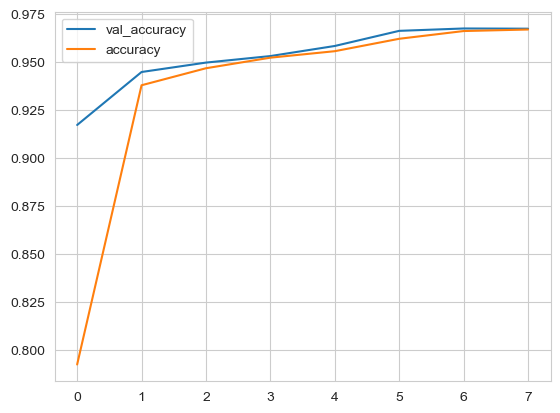

In [56]:
mc_df[['val_accuracy','accuracy']].plot()

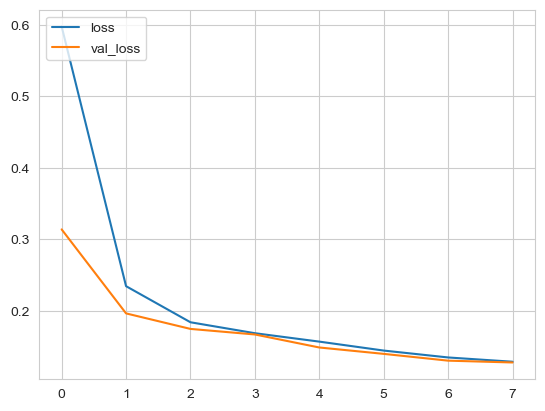

In [82]:
mc_df[['loss','val_loss']].plot()
plt.legend(loc='upper left')

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
predictions = nnet_multiclass.predict(X_test)

2006/2006 [==============================] - 3s 2ms/step


In [74]:
pred_encoded = [classes[predictions[i].argmax()] for i in range(len(predictions))]

In [71]:
_, _, _, y = train_test_split(X, y_resampled, test_size=0.3, random_state=101)

In [80]:
print(classification_report(y_true=y,y_pred=pred_encoded))

                 precision    recall  f1-score   support

        BATTERY       0.99      0.92      0.96     12839
CRIMINAL DAMAGE       1.00      0.97      0.98     12777
      NARCOTICS       0.94      0.99      0.96     12937
        ROBBERY       0.92      0.95      0.93     12692
          THEFT       1.00      1.00      1.00     12943

       accuracy                           0.97     64188
      macro avg       0.97      0.97      0.97     64188
   weighted avg       0.97      0.97      0.97     64188



Text(0.5, 1.0, 'Confusion Matrix')

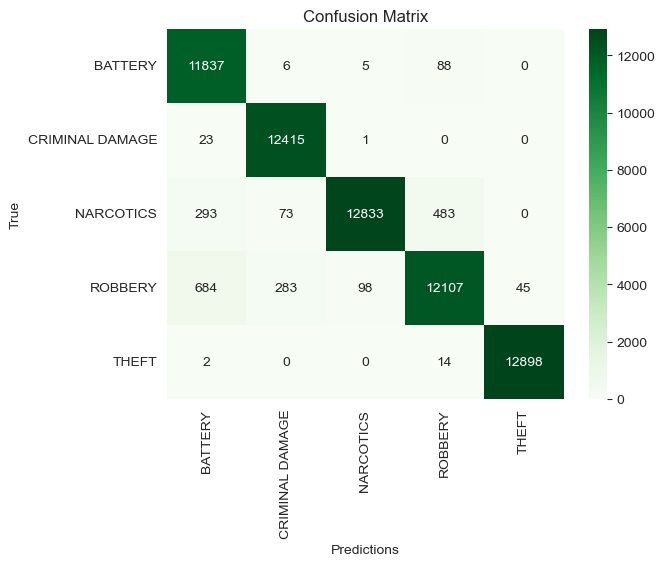

In [83]:
sns.heatmap(confusion_matrix(pred_encoded, y), annot=True, cmap='Greens', fmt='d', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predictions')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [81]:
nnet_multiclass.save('CRIME_CLASSIFIER_NET.h5')

In [96]:
#final_data.to_csv('nn_data.csv')
x = pd.DataFrame(X_test)
x['y'] = y 
x = x.dropna()
x.to_csv('nn_data.csv')

### Loading model

In [100]:
data = pd.read_csv('nn_data.csv').drop('Unnamed: 0',axis=1)
X, y = data.drop('y',axis=1), data['y']

In [119]:
y_idx = np.random.choice(X.index)
X.iloc[np.random.choice(X.index),:], y[y_idx]

(0    2.314468
 1   -0.195402
 2   -0.282690
 3   -0.477780
 4   -0.513857
 5    1.348395
 6    0.493020
 Name: 13164, dtype: float64,
 'BATTERY')

In [ ]:
X.iloc[np.random.choice(.index),:]

In [112]:
X.iloc[np.random.choice(X.index),:]

0   -0.432065
1   -0.298357
2    0.325414
3   -0.684086
4   -0.513857
5   -0.040202
6   -1.523448
Name: 2824, dtype: float64

In [86]:
import tensorflow as tf
from tensorflow import keras

# Load the trained model
model = keras.models.load_model('CRIME_CLASSIFIER_NET.h5')

In [109]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 dense_4 (Dense)             (None, 25)                425       
                                                                 
 dense_5 (Dense)             (None, 5)                 130       
                                                                 
Total params: 683
Trainable params: 683
Non-trainable params: 0
_________________________________________________________________


In [114]:
X.shape

(19216, 7)

In [117]:
np.array(X.iloc[np.random.choice(X.index),:]).reshape(-1,7)

array([[-0.43206474, -0.24687942, -0.93757046, -0.47778013, -0.51385697,
        -0.04020164, -0.01109682]])

In [118]:
model.predict(np.array(X.iloc[np.random.choice(X.index),:]).reshape(-1,7))

1/1 [==============================] - 0s 469ms/step


array([[2.8713357e-05, 5.1019951e-23, 1.0105472e-21, 1.6068623e-05,
        9.9995518e-01]], dtype=float32)

In [120]:
['Arrest', 'Description', 'Community Area', 'Location Description', 'Domestic', 'SocioEconomic-Status', 'dayofweek']

['Arrest',
 'Description',
 'Community Area',
 'Location Description',
 'Domestic',
 'SocioEconomic-Status',
 'dayofweek']

In [123]:
test = crimes[features].iloc[0]
test

Arrest                        False
Description                  SIMPLE
Community Area                   30
Location Description      APARTMENT
Domestic                      False
SocioEconomic-Status    High Income
dayofweek                       Mon
Name: 0, dtype: object

In [144]:
#crimes[features]

In [146]:
crime_type.head(5)

,Arrest,Description,Community Area,Location Description,Domestic,SocioEconomic-Status,dayofweek,Primary Type
1,False,0,6,0,False,0,0,THEFT
3,True,1,55,1,True,1,0,BATTERY
4,False,2,8,1,False,0,0,THEFT
7,False,0,8,2,False,0,0,THEFT
8,False,2,8,1,False,0,0,THEFT


In [151]:
crime_type[wanted].columns

Index(['Description', 'Location Description', 'SocioEconomic-Status',
       'dayofweek'],
      dtype='object')

,Arrest,Description,Community Area,Location Description,Domestic,SocioEconomic-Status,dayofweek
0,False,SIMPLE,30,APARTMENT,False,High Income,Mon
1,False,FROM BUILDING,6,APARTMENT,False,Low Income,Mon
2,False,NON-AGGRAVATED,3,RESIDENCE,True,Moderate Income,Mon
3,True,DOMESTIC BATTERY SIMPLE,55,BAR OR TAVERN,True,Moderate Income,Mon
4,False,POCKET-PICKING,8,BAR OR TAVERN,False,Low Income,Mon
...,...,...,...,...,...,...,...
1175724,False,TO PROPERTY,26,SMALL RETAIL STORE,False,High Income,Sat
1175725,False,SIMPLE,29,APARTMENT,False,High Income,Sat
1175726,False,AGGRAVATED - HANDGUN,68,APARTMENT,True,High Income,Sat
1175727,False,SIMPLE,28,BARBERSHOP,False,Moderate Income,Sat


In [163]:
wanted = ['Description','Location Description','SocioEconomic-Status','dayofweek']
for i, col in enumerate(wanted):
    x[f"map{i}"] = crime_type[col]
    


/var/folders/5r/pnlff12n2d55g65_tnn3b1pw0000gn/T/ipykernel_66104/3176939844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[f"map{i}"] = crime_type[col]
/var/folders/5r/pnlff12n2d55g65_tnn3b1pw0000gn/T/ipykernel_66104/3176939844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[f"map{i}"] = crime_type[col]
/var/folders/5r/pnlff12n2d55g65_tnn3b1pw0000gn/T/ipykernel_66104/3176939844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [166]:
x = x.dropna()

In [174]:
desc_map = dict(x[['Description','map0']].values)
loc_map = dict(x[['Location Description','map1']].values)
soc_map = dict(x[['SocioEconomic-Status','map2']].values)
day_map = dict(x[['dayofweek','map3']].values)

In [178]:
import pickle
# save the dictionary to a file using pickle.dump()
with open('desc_map.pkl', 'wb') as f:
    pickle.dump(desc_map, f)
with open('loc_map.pkl', 'wb') as f:
    pickle.dump(loc_map, f)
with open('soc_map.pkl', 'wb') as f:
    pickle.dump(soc_map, f)
with open('day_map.pkl', 'wb') as f:
    pickle.dump(day_map, f)
                
                
                


In [179]:
with open('desc_map.pkl', 'rb') as f:
    desc_map = pickle.load(f)
with open('loc_map.pkl', 'rb') as f:
    loc_map = pickle.load(f)
with open('soc_map.pkl', 'rb') as f:
    soc_map = pickle.load(f)
with open('day_map.pkl', 'rb') as f:
    day_map = pickle.load(f)




{'Mon': 0.0,
 'Tue': 1.0,
 'Wed': 2.0,
 'Fri': 3.0,
 'Sat': 4.0,
 'Sun': 5.0,
 'Thu': 6.0}

In [181]:
desc_map

{'FROM BUILDING': 0.0,
 'DOMESTIC BATTERY SIMPLE': 1.0,
 'POCKET-PICKING': 2.0,
 'TO VEHICLE': 3.0,
 'POSS: CRACK': 4.0,
 'AGGRAVATED: HANDGUN': 5.0,
 'TO PROPERTY': 6.0,
 'POSS: HEROIN(WHITE)': 7.0,
 'ARMED: HANDGUN': 8.0,
 '$500 AND UNDER': 9.0,
 'SIMPLE': 10.0,
 'OVER $500': 11.0,
 'AGGRAVATED': 12.0,
 'RETAIL THEFT': 13.0,
 'AGG: HANDS/FIST/FEET NO/MINOR INJURY': 14.0,
 'VEHICULAR HIJACKING': 15.0,
 'TO CITY OF CHICAGO PROPERTY': 16.0,
 'AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET SERIOUS INJURY': 17.0,
 'STRONGARM - NO WEAPON': 18.0,
 'ARMED:KNIFE/CUTTING INSTRUMENT': 19.0,
 'POSS: COCAINE': 20.0,
 'AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON': 21.0,
 'AGGRAVATED: OTHER DANG WEAPON': 22.0,
 'POSS: SYNTHETIC DRUGS': 23.0,
 'AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST': 24.0,
 'ATTEMPT: ARMED-HANDGUN': 25.0,
 'CRIMINAL DEFACEMENT': 26.0,
 'POSS: CANNABIS MORE THAN 30GMS': 27.0,
 'PRO EMP HANDS NO/MIN INJURY': 28.0,
 'POSS: CANNABIS 30GMS OR LESS': 29.0,
 'AGGRAVATED VEHICULA

In [190]:
day_map

{'Mon': 0.0,
 'Tue': 1.0,
 'Wed': 2.0,
 'Fri': 3.0,
 'Sat': 4.0,
 'Sun': 5.0,
 'Thu': 6.0}

In [175]:
test = crimes[features].iloc[0]
test

Arrest                        False
Description                  SIMPLE
Community Area                   30
Location Description      APARTMENT
Domestic                      False
SocioEconomic-Status    High Income
dayofweek                       Mon
Name: 0, dtype: object

In [204]:
input_list = np.array([False, 10.0, 30, 0.0, False , 2.0, 0.0 ]

In [206]:
model.predict(input_list.reshape(-1,7))

1/1 [==============================] - 0s 19ms/step


array([[2.4630709e-02, 6.7587388e-07, 5.1005356e-02, 9.2435932e-01,
        3.9184661e-06]], dtype=float32)